<a href="https://colab.research.google.com/github/MirandaCarou/Research-Intership-Memory/blob/main/QGANS_with_qubits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit-machine-learning #

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.6/231.6 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 5.7 MB/s eta 0:00:00


In [ ]:
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=977a8727dcc9e98ae995119319c9c28cb7b44a7ec7fbdf67a600c93a464f979a
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc


In [ ]:
!pip install qiskit
!pip install qiskit-aer
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 43.8 MB/s eta 0:00:00


## **Based in this paper:**

[Quantum Generative Adversarial Networks for Learning and Loading Random Distributions](https://arxiv.org/abs/1904.00043)


In [ ]:
from qiskit_aer import Aer
from qiskit.utils import *

# Load and preprocess the Iris dataset
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
import numpy as np

iris = load_iris()
data = iris.data
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)


In [ ]:
import torch
import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN

# Set random seeds for reproducibility
algorithm_globals.random_seed = 123456
torch.manual_seed(123456)

# Load the Iris dataset
iris = load_iris()
X = iris.data  # Features (4 dimensions)

# Normalize the features to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
X_normalized = scaler.fit_transform(X)


# Fix the number of dimensions and discretization number
num_dim = X.shape[1]  # Number of features in the Iris dataset
num_discrete_values = 4  # Number of discrete values per feature

# Compute the number of qubits required
num_qubits = num_dim * int(np.ceil(np.log2(num_discrete_values)))
print(f"Number of dimensions:  {num_dim}")
print(f"Number of qubits required: {num_qubits}")

# Prepare a discrete distribution from the normalized Iris dataset
coords = np.linspace(0, 1, num_discrete_values)  # Range [0, 1] due to normalization
grid_elements = np.array(np.meshgrid(*[coords] * num_dim)).T.reshape(-1, num_dim)

# Compute probabilities for the discretized Iris dataset using Kernel Density Estimation (KDE)
kde = gaussian_kde(X_normalized.T)  # Transpose to match KDE input format
prob_data = kde(grid_elements.T)  # Evaluate KDE on the grid
prob_data = prob_data / np.sum(prob_data)  # Normalize to form a discrete distribution

# Print the shape of the probability distribution
print(f"Shape of the probability distribution: {prob_data.shape}")

Number of dimensions:  4
Number of qubits required: 8
Shape of the probability distribution: (256,)


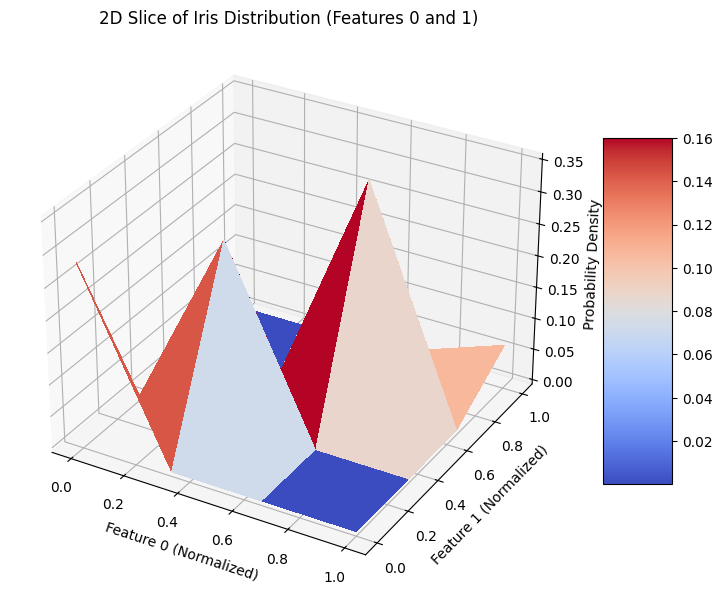

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

# Define the coordinates for the discretized grid
coords = np.linspace(0, 1, num_discrete_values)  # Range [0, 1] due to normalization

# Create a meshgrid for two features at a time
mesh_x, mesh_y = np.meshgrid(coords, coords)
grid_shape = (num_discrete_values, num_discrete_values)

# Reshape the probability distribution into a 4D grid
prob_grid_4d = np.reshape(prob_data, (num_discrete_values, num_discrete_values, num_discrete_values, num_discrete_values))

# Choose two features to visualize (e.g., feature 0 and feature 1)
feature_x = 0  # Sepal Length
feature_y = 1  # Sepal Width

# Marginalize over the other two features (feature 2 and feature 3)
prob_grid_2d = np.sum(prob_grid_4d, axis=(2, 3))

# Plot the 2D slice
fig, ax = plt.subplots(figsize=(9, 9), subplot_kw={"projection": "3d"})
surf = ax.plot_surface(mesh_x, mesh_y, prob_grid_2d, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel(f"Feature {feature_x} (Normalized)")
ax.set_ylabel(f"Feature {feature_y} (Normalized)")
ax.set_zlabel("Probability Density")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title(f"2D Slice of Iris Distribution (Features {feature_x} and {feature_y})")
plt.show()

##Definition of the quantum neural network ansatz
To implement the quantum generator, we choose a hardware efficient ansatz with repetitions. The ansatz implements $R_y, R_Z$ rotations and $C_X$ gates which takes a uniform distribution as an input state. Notably, for $k>1$ the generator’s parameters must be chosen carefully. For example, the circuit depth should be more than because higher circuit depths enable the representation of more complex structures. Here, we construct quite a deep circuit with a large number of parameters to be able to adequately capture and represent the distribution.

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2, TwoLocal
qc = QuantumCircuit(num_qubits)
qc.h(qc.qubits)

ansatz = EfficientSU2(num_qubits, reps=6)

#Probar!!
'''ansatz = TwoLocal(num_qubits=num_qubits,
                           rotation_blocks='ry',
                           entanglement_blocks='cz',
                           reps=4,
                           insert_barriers=True)'''
qc.compose(ansatz, inplace=True)

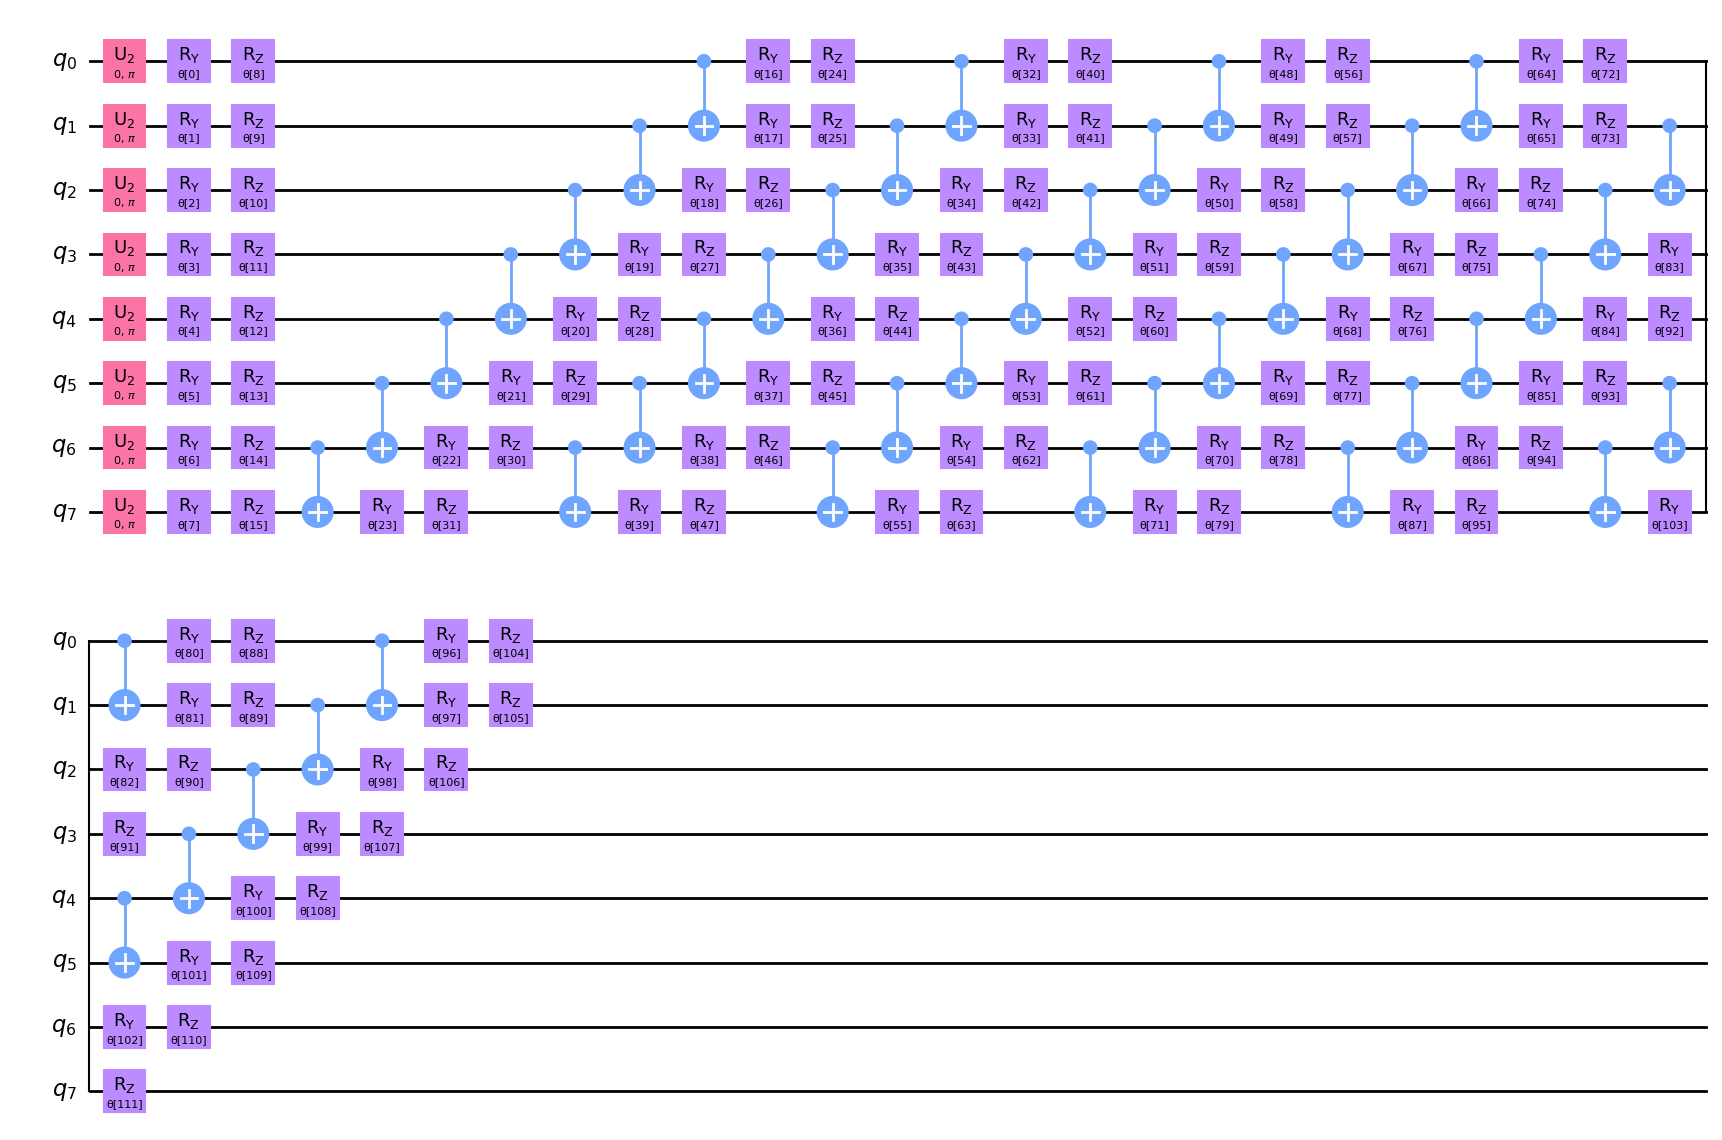

In [ ]:
qc.decompose().draw(output="mpl", style="clifford")

In [ ]:
qc.num_parameters

112

##Definition of the quantum generator
We start defining the generator by creating a sampler for the ansatz. The reference implementation is a statevector-based implementation, thus it returns exact probabilities as a result of circuit execution. In this case the implementation samples probabilities from the multinomial distribution constructed from the measured quasi probabilities.

In [ ]:
from qiskit.primitives import StatevectorSampler as Sampler

sampler = Sampler()

Next, we define a function that creates the quantum generator from a given parameterized quantum circuit. Inside this function we create a neural network that returns the quasi probability distribution evaluated by the underlying Sampler. We fix initial_weights for reproducibility purposes. In the end we wrap the created quantum neural network in TorchConnector to make use of PyTorch-based training.

In [ ]:
def create_generator() -> TorchConnector:
    qnn = SamplerQNN(
        circuit=qc,
        sampler=sampler,
        input_params=[],
        weight_params=qc.parameters,
        sparse=False,
    )

    initial_weights = algorithm_globals.random.random(qc.num_parameters)
    return TorchConnector(qnn, initial_weights)

## Definition of the classical discriminator
Next, we define a PyTorch-based classical neural network that represents the classical discriminator. The underlying gradients can be automatically computed with PyTorch.

In [ ]:
from torch import nn


class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        self.linear_input = nn.Linear(input_size, 20)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear20 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(input)
        x = self.leaky_relu(x)
        x = self.linear20(x)
        x = self.sigmoid(x)
        return x

In [ ]:
generator = create_generator()
discriminator = Discriminator(num_dim)

##Setting up the Training Loop

  * A loss function for the generator and discriminator.

  * Optimizers for both.

  * A utility plotting function to visualize training process.

(Añadir info : https://qiskit-community.github.io/qiskit-machine-learning/tutorials/04_torch_qgan.html)

In [ ]:
def adversarial_loss(input, target, w):
    bce_loss = target * torch.log(input) + (1 - target) * torch.log(1 - input)
    weighted_loss = w * bce_loss
    total_loss = -torch.sum(weighted_loss)
    return total_loss

## Definition of the optimizers
In order to train the generator and discriminator, we need to define optimization schemes. In the following, we employ a momentum based optimizer called Adam, see Kingma et al., Adam: A method for stochastic optimization for more details.

In [ ]:
from torch.optim import Adam

lr = 0.01  # learning rate
b1 = 0.7  # first momentum parameter
b2 = 0.999  # second momentum parameter

generator_optimizer = Adam(generator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005)
discriminator_optimizer = Adam(
    discriminator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005
)

#generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.01)
#discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.01)

## Visualization of the training process

We will visualize what is happening during the training by plotting the evolution of the generator’s and the discriminator’s loss functions during the training, as well as the progress in the relative entropy between the trained and the target distribution. We define a function that plots the loss functions and relative entropy. We call this function once an epoch of training is complete.

Visualization of the training process begins when training data is collected across two epochs.

In [ ]:
from IPython.display import clear_output


def plot_training_progress():
    # we don't plot if we don't have enough data
    if len(generator_loss_values) < 2:
        return

    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    # Generator Loss
    ax1.set_title("Loss")
    ax1.plot(generator_loss_values, label="generator loss", color="royalblue")
    ax1.plot(discriminator_loss_values, label="discriminator loss", color="magenta")
    ax1.legend(loc="best")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Loss")
    ax1.grid()

    # Relative Entropy
    ax2.set_title("Relative entropy")
    ax2.plot(entropy_values)
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Relative entropy")
    ax2.grid()

    plt.show()

##Model Training

In the training loop we monitor not only loss functions, but relative entropy as well. The relative entropy describes a distance metric for distributions. Hence, we can use it to benchmark how close/far away the trained distribution is from the target distribution.

Now, we are ready to train our model. It may take some time to train the model so be patient.

1. **Generator Loss**: This helps you track how well the generator is learning to produce realistic data over time. Lower generator loss typically indicates better performance.

2. **Discriminator Loss**: This also gives an idea of how well the discriminator is distinguishing between real and generated data. You want both the generator and discriminator to improve as the training progresses.

3. **Entropy**: You are computing the entropy of the generated data and comparing it to the probability distribution of the real data. Lower entropy indicates that the generated distribution is more similar to the real distribution.

In [ ]:
def plot_training_progress():
    clear_output(wait=True)
    plt.figure(figsize=(18, 4))

    # Plot generator and discriminator loss
    plt.subplot(1, 3, 1)
    plt.plot(generator_loss_values, label="Generator Loss")
    plt.plot(discriminator_loss_values, label="Discriminator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Generator and Discriminator Loss")
    plt.legend()

    # Plot entropy
    plt.subplot(1, 3, 2)
    plt.plot(entropy_values, label="Entropy")
    plt.plot(kl_values, label="KL Divergence")
    plt.plot(js_values, label="JS Divergence")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.title("Distribution Metrics")
    plt.legend()

    # Plot Wasserstein distance
    plt.subplot(1, 3, 3)
    plt.plot(wass_values, label="Wasserstein Distance")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.title("Wasserstein Distance")
    plt.legend()

    plt.tight_layout()
    plt.show()

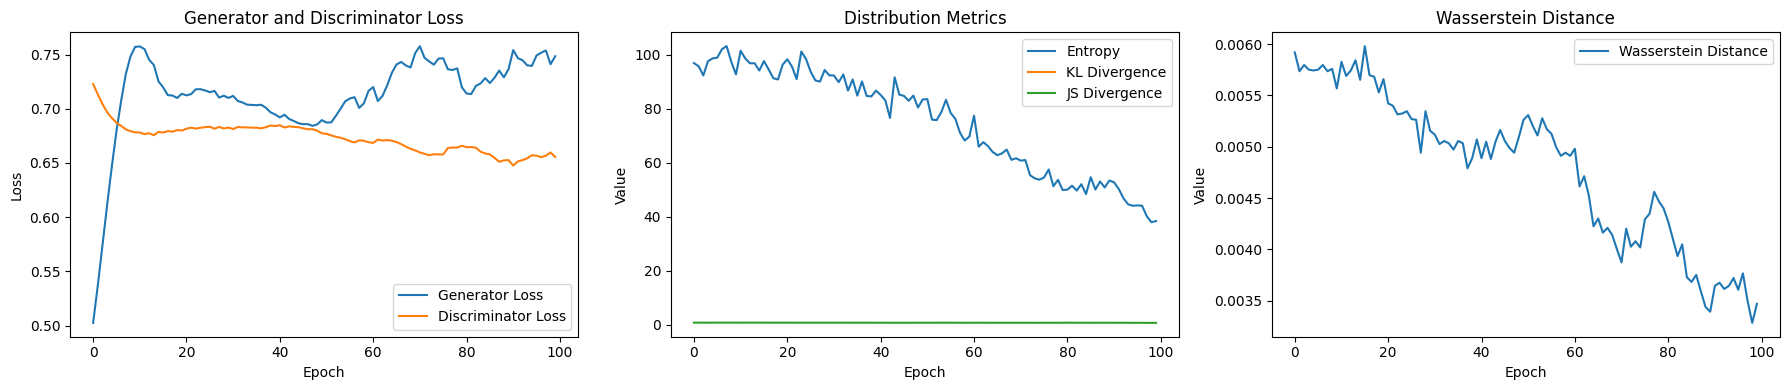

Training completed in 419.41 seconds


In [ ]:
import time
import torch
import numpy as np
from scipy.stats import entropy, wasserstein_distance
from scipy.special import kl_div
from scipy.spatial.distance import jensenshannon
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Hyperparameters
n_epochs = 100
num_qnn_outputs = num_discrete_values**num_dim

# Lists to store training progress
generator_loss_values = []
discriminator_loss_values = []
entropy_values = []
kl_values = []
js_values = []
wass_values = []

# Start training
start = time.time()
for epoch in range(n_epochs):
    # Labels for real and fake data
    valid = torch.ones(num_qnn_outputs, 1, dtype=torch.float)  # Real data label
    fake = torch.zeros(num_qnn_outputs, 1, dtype=torch.float)  # Fake data label

    # Prepare real data distribution
    real_dist = torch.tensor(prob_data, dtype=torch.float).reshape(-1, 1)

    # Prepare grid samples for evaluation
    samples = torch.tensor(grid_elements, dtype=torch.float)
    disc_value = discriminator(samples)  # Discriminator's output for generated samples

    # Generate fake data using the quantum generator (QNN)
    gen_dist = generator(torch.tensor([])).reshape(-1, 1)  # Assuming generator is a QNN

    # Train the generator
    generator_optimizer.zero_grad()
    generator_loss = adversarial_loss(disc_value, valid, gen_dist)  # Generator tries to fool discriminator

    # Store generator loss for plotting
    generator_loss_values.append(generator_loss.detach().item())

    # Backpropagate and update generator weights
    generator_loss.backward(retain_graph=True)
    generator_optimizer.step()

    # Train the discriminator
    discriminator_optimizer.zero_grad()

    # Discriminator loss for real data
    real_loss = adversarial_loss(discriminator(samples), valid, real_dist)

    # Discriminator loss for fake data
    fake_loss = adversarial_loss(discriminator(samples), fake, gen_dist.detach())

    # Total discriminator loss
    discriminator_loss = (real_loss + fake_loss) / 2

    # Store discriminator loss for plotting
    discriminator_loss_values.append(discriminator_loss.detach().item())

    # Backpropagate and update discriminator weights
    discriminator_loss.backward()
    discriminator_optimizer.step()

    # Compute metrics
    gen_dist_np = gen_dist.detach().squeeze().numpy()
    entropy_value = entropy(gen_dist_np, prob_data)
    kl_value = np.sum(kl_div(prob_data, gen_dist_np))
    js_value = jensenshannon(prob_data, gen_dist_np)
    wass_value = wasserstein_distance(prob_data, gen_dist_np)

    # Store metrics for plotting
    entropy_values.append(entropy_value)
    kl_values.append(kl_value)
    js_values.append(js_value)
    wass_values.append(wass_value)

    # Plot training progress
    plot_training_progress()

# Training complete
elapsed = time.time() - start
print(f"Training completed in {elapsed:0.2f} seconds")

In [ ]:
# Al final del entrenamiento, imprime las métricas finales
print("\nMétricas Finales:")
print(f"Entropía final: {entropy_values[-1]:.4f}")
print(f"Divergencia KL final: {kl_values[-1]:.4f}")
print(f"Divergencia JS final: {js_values[-1]:.4f}")
print(f"Distancia de Wasserstein final: {wass_values[-1]:.4f}")


Métricas Finales:
Entropía final: 38.4185
Divergencia KL final: inf
Divergencia JS final: 0.7048
Distancia de Wasserstein final: 0.0035


In [ ]:
print("Distribución real (prob_data):")
print(f"Mínimo: {np.min(prob_data)}, Máximo: {np.max(prob_data)}")
print(f"¿Hay valores cero? {np.any(prob_data == 0)}")

Distribución real (prob_data):
Mínimo: 4.135267975378937e-272, Máximo: 0.1867138774079633
¿Hay valores cero? False


In [ ]:
print("Distribución generada (gen_dist):")
print(f"Mínimo: {np.min(gen_dist.detach().numpy())}, Máximo: {np.max(gen_dist.detach().numpy())}")
print(f"¿Hay valores cero? {np.any(gen_dist.detach().numpy() == 0)}")

Distribución generada (gen_dist):
Mínimo: 0.0, Máximo: 0.1298828125
¿Hay valores cero? True


In [ ]:
# Calcular la divergencia KL manualmente para verificar
kl_manual = np.sum(prob_data * np.log(prob_data / gen_dist.detach().squeeze().numpy()))
print(f"Divergencia KL manual: {kl_manual}")

Divergencia KL manual: inf


<ipython-input-128-2b4523e576c4>:2: RuntimeWarning: divide by zero encountered in divide
  kl_manual = np.sum(prob_data * np.log(prob_data / gen_dist.detach().squeeze().numpy()))


In [ ]:
print(f"Suma de prob_data: {np.sum(prob_data)}")
print(f"Suma de gen_dist: {np.sum(gen_dist.detach().squeeze().numpy())}")

Suma de prob_data: 1.0
Suma de gen_dist: 1.0




---

## Another posible approach  

---



In [ ]:
def adversarial_loss(input, target, w):
    bce_loss = target * torch.log(input) + (1 - target) * torch.log(1 - input)
    weighted_loss = w * bce_loss
    total_loss = -torch.sum(weighted_loss)
    return total_loss

In [ ]:
from IPython.display import clear_output


def plot_training_progress():
    # we don't plot if we don't have enough data
    if len(generator_loss_values) < 2:
        return

    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    # Generator Loss
    ax1.set_title("Loss")
    ax1.plot(generator_loss_values, label="generator loss", color="royalblue")
    ax1.plot(discriminator_loss_values, label="discriminator loss", color="magenta")
    ax1.legend(loc="best")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Loss")
    ax1.grid()

    # Relative Entropy
    ax2.set_title("Relative entropy")
    ax2.plot(entropy_values)
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Relative entropy")
    ax2.grid()

    plt.show()

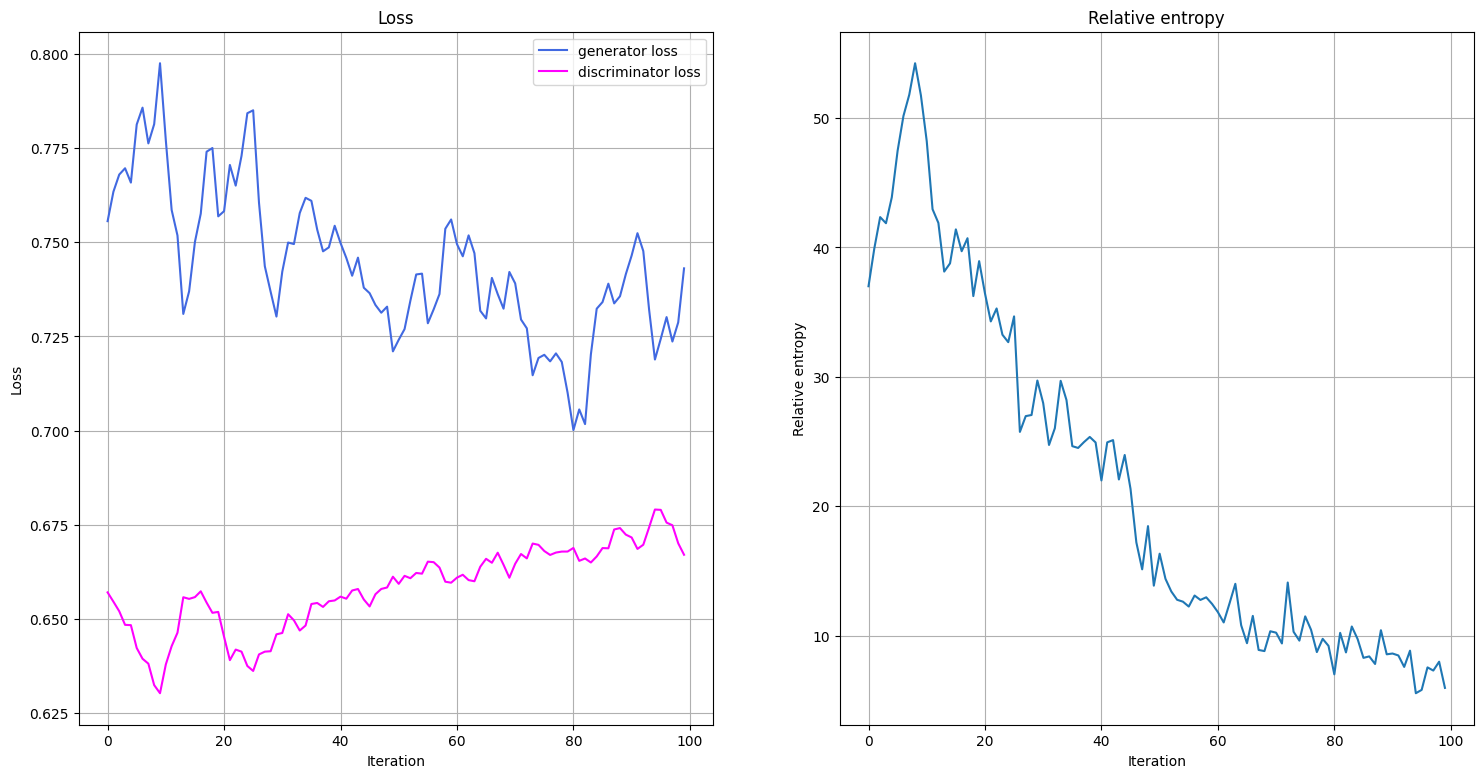

Fit in 413.72 sec


In [ ]:
import time
from scipy.stats import multivariate_normal, entropy
from IPython.display import clear_output
import matplotlib.pyplot as plt # Importing the matplotlib library

n_epochs = 100

num_qnn_outputs = num_discrete_values**num_dim

generator_loss_values = []
discriminator_loss_values = []
entropy_values = []

start = time.time()
for epoch in range(n_epochs):

    valid = torch.ones(num_qnn_outputs, 1, dtype=torch.float)
    fake = torch.zeros(num_qnn_outputs, 1, dtype=torch.float)

    # Configure input
    real_dist = torch.tensor(prob_data, dtype=torch.float).reshape(-1, 1)

    # Configure samples
    samples = torch.tensor(grid_elements, dtype=torch.float)
    disc_value = discriminator(samples)

    # Generate data
    gen_dist = generator(torch.tensor([])).reshape(-1, 1)

    # Train generator
    generator_optimizer.zero_grad()
    generator_loss = adversarial_loss(disc_value, valid, gen_dist)

    # store for plotting
    generator_loss_values.append(generator_loss.detach().item())

    generator_loss.backward(retain_graph=True)
    generator_optimizer.step()

    # Train Discriminator
    discriminator_optimizer.zero_grad()

    real_loss = adversarial_loss(disc_value, valid, real_dist)
    fake_loss = adversarial_loss(disc_value, fake, gen_dist.detach())
    discriminator_loss = (real_loss + fake_loss) / 2

    # Store for plotting
    discriminator_loss_values.append(discriminator_loss.detach().item())

    discriminator_loss.backward()
    discriminator_optimizer.step()

    entropy_value = entropy(gen_dist.detach().squeeze().numpy(), prob_data)
    entropy_values.append(entropy_value)

    plot_training_progress()

elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} sec")

## Results: Cumulative Density Functions

In [ ]:
from scipy.stats import wasserstein_distance
from scipy.special import kl_div

w_distance = wasserstein_distance(prob_data, gen_dist.detach().numpy().flatten())
print(f"Wasserstein Distance: {w_distance}")

kl_divergence = np.sum(kl_div(prob_data, gen_dist.detach().numpy().flatten()))
print(f"KL Divergence: {kl_divergence}")

mse = np.mean((prob_data - gen_dist.detach().numpy().flatten()) ** 2)
print(f"Mean Squared Error: {mse}")

Wasserstein Distance: 0.002234217261334118
KL Divergence: inf
Mean Squared Error: 0.0005028181657564316


qGAN is performing well in terms of Wasserstein distance and MSE, but the KL divergence indicates that there are regions where the generated distribution does not fully match the real distribution. By addressing the zero-probability issue and experimenting with hyperparameters, you can further improve the performance of your qGAN.

In [ ]:
## Add a small constant to avoid zero probabilities
fix_gen_dist = gen_dist.detach().numpy().flatten() + 1e-10
kl_divergence = np.sum(kl_div(prob_data, fix_gen_dist))

kl_divergence = np.sum(kl_div(prob_data, fix_gen_dist))
print(f"KL Divergence: {kl_divergence}")



KL Divergence: 8.954407056191098
